# Object Detection

In this tutorial, you will learn:
- the basic structure of Faster R-CNN.
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# To resolve the version conflicts of PILLOW, we reinstall PILLOW==7.0.0
!pip install PILLOW==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.5.1+cu101 in /usr/local/lib/python3.6/dist-packages (1.5.1+cu101)
Requirement already up-to-date: torchvision==0.6.1+cu101 in /usr/local/lib/python3.6/dist-packages (0.6.1+cu101)
     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 194kB 8.8MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.0.4-cp36-cp36m-linux_x86_64.whl size=16279808 sha256=8f678914f54581ea68a89c200be47918a046ed913744a61013313f5eb8b6ee72
  Stored in directory: /root/.cache/pip/wheels/58/0b/6d/a934c5e7d2507564f7b22291db3f327a06c7808d8e6cdba18f
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 12434, done.
remote: Total 12434 (delta 0), reused 0 (delta 0), pack-reused 12434
Receiving objects: 100% (12434/12434), 11.48 MiB | 7.00 MiB/s, done.
Resolving deltas: 100% (8538/8538), done.
/content/mmdetection
Obtaining file:///cont

     |████████████████████████████████| 2.1MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: mmdet 2.3.0rc0+8194b16 has requirement Pillow<=6.2.2, but you'll have pillow 7.0.0 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.3.0rc0+8194b16
10.1
GCC 7.5


## Perform Inference with An MMDet detector



### A two-stage detector

In this tutorial, we use Faster R-CNN, a simple two-stage detector as an example.

The high-level architecture of Faster R-CNN is shown in the following picture. More details can be found in the [paper](https://arxiv.org/abs/1506.01497).

![faster rcnn](https://pic1.zhimg.com/80/v2-c0172be282021a1029f7b72b51079ffe_1440w.jpg)

Briefly, it uses a convolutional neural network (CNN) as backbone to extract features from an image. Then, it uses a region proposal network (RPN) to predict proposals, i.e., potential objects. After that, it uses a feature extractor to crop features for the region of interests (RoI), and uses a RoI Head to perform classification and bounding box prediction.



In [ ]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth

--2020-07-29 05:08:19--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.58.35
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.58.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291065 (160M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth’

checkpoints/faster_ 100%[===================>] 159.54M  45.7MB/s    in 3.5s    

2020-07-29 05:08:23 (45.7 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth’ saved [167291065/167291065]



In [ ]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model, test_cfg=config.test_cfg)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [ ]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

In [ ]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

## Train A Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. Reorganize the dataset into a COCO format.
  2. Reorganize the dataset into a middle format.
  3. Implement a new dataset.

We recommend the first two methods, as they are usually easier than the third one.

In this tutorial, we give an example that converts the data into the formats of existing datasets, e.g. COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

First, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but with 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of the dataset.

In [ ]:
# download, decompress the data
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2020-07-29 05:08:42--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.58.47
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.58.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  11.7MB/s    in 0.6s    

2020-07-29 05:08:43 (11.7 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [ ]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (45.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpe

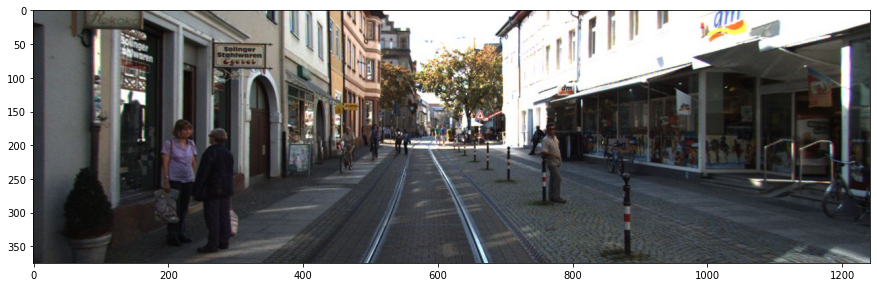

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the KITTI annotation format into the middle format. In this tutorial, we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a loot at the annotation txt file.



In [ ]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicate the bboxes. We need to read annotations of each image and convert them into middle format that MMDetection can accept, as follows:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset. We modify the config of datasets, learning rate schedules, and runtime settings.

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector! We use the high-level API `train_detector` implemented by MMDetection. This is also used in our training scripts. For details of the implementation, please see [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/train.py).

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-07-29 05:09:04,069 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
Downloading: "https://open-mmlab.s3.ap-northeast-2.amazonaws.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/checkpoints/resnet50_msra-5891d200.pth


2020-07-29 05:09:06,775 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias



2020-07-29 05:09:07,081 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_bbox_mAP-0.398_20200504_163323-30042637.pth
2020-07-29 05:09:07,204 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
2020-07-29 05:09:07,207 - mmdet - INFO - Start running, host: root@a32be271b3f

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 15.9 task/s, elapsed: 2s, ETA:     0s

2020-07-29 05:10:50,129 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 141  | 0.935  | 0.858 |
| Pedestrian | 13  | 61   | 0.846  | 0.767 |
| Cyclist    | 7   | 59   | 0.429  | 0.037 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.554 |
+------------+-----+------+--------+-------+
2020-07-29 05:10:50,131 - mmdet - INFO - Epoch [12][25/25]	lr: 2.500e-05, mAP: 0.5539


### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more costly. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a pre-trained Faster R-CNN model and finetune it for detection. 
The original Faster R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Faster R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset, not bad!

We can also check the tensorboard to see the curves.

In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps

<IPython.core.display.Javascript object>

From the tensorboard, we can observe that changes of loss and learning rate. We can see the losses of each branch gradually decrease as the training goes by.

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

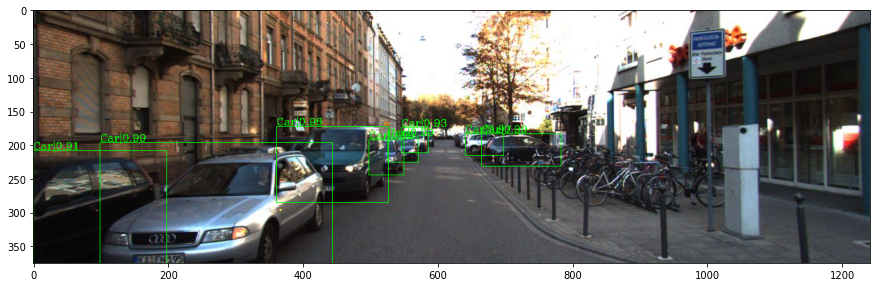

In [ ]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


## What to Do Next?

So far, we have learnt how to test and train a two-stage detector using MMDetection. To further explore MMDetection, you could do several other things as shown below:

- Try single-stage detectors, e.g., [RetinaNet](https://github.com/open-mmlab/mmdetection/tree/master/configs/retinanet) and [SSD](https://github.com/open-mmlab/mmdetection/tree/master/configs/ssd) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/model_zoo.md). Single-stage detectors are more commonly used than two-stage detectors in industry.
- Try anchor-free detectors, e.g., [FCOS](https://github.com/open-mmlab/mmdetection/tree/master/configs/fcos) and [RepPoints](https://github.com/open-mmlab/mmdetection/tree/master/configs/reppoints) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/model_zoo.md). Anchor-free detector is a new trend in the object detection community.
- Try 3D object detection using [MMDetection3D](https://github.com/open-mmlab/mmdetection3d), also one of the OpenMMLab projects. In MMDetection3D, not only can you try all the methods supported in MMDetection but also some 3D object detectors.
